In [1]:
import numpy as np 

import matplotlib.pyplot as plt
plt.rcParams["axes.labelsize"] = 10   # axis labels
plt.rcParams["xtick.labelsize"] = 12  # x-axis tick labels
plt.rcParams["ytick.labelsize"] = 12  # y-axis tick labels
plt.rcParams["font.family"] = "serif"

import pandas as pd
pd.set_option("display.float_format", "{:.3e}".format)  # 2 sig. figs in exponential form


import sys
from tools_tolgay import functions_cloudy
from tools_tolgay import constants

import importlib

from scipy import integrate

# H  1                6562.80A

In [2]:
importlib.reload(functions_cloudy)

fdir = "/scratch/dtolgay/cloudy_runs/z_0/check_cloudy"

runs = {
    'original':{
        "base_file_path": f"{fdir}/old_cloudy",
        "file_props" :{
            "log_hden": 2, # 1/cm3 
            "log_metallicity": 0.5, # Zsolar
            "log_turbulence": 0, # km/s
            "log_isrf": 0, # G0
            "log_radius": 2 # pc
        },         
        "emissivity": pd.DataFrame(),
        "abundance": pd.DataFrame(),
        "label": "Old run", 
        "color": "red",
    },
    'run2':{
        "base_file_path": f"{fdir}/new_cloudy", 
        "file_props" :{
            "log_hden": 2, # 1/cm3 
            "log_metallicity": 0.5, # Zsolar
            "log_turbulence": 0, # km/s
            "log_isrf": 0, # G0
            "log_radius": 2 # pc
        },            
        "emissivity": pd.DataFrame(),
        "abundance": pd.DataFrame(),
        "label": "New run", 
        "color": "orange",
    },
}

for key, value in runs.items():
    run_ = 'key'
    file_props = value['file_props']
    base_file_path = value['base_file_path']
    # print all of the files in the directory
    import os
    files = os.listdir(f"{base_file_path}/hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000")
    print(f"Files in {base_file_path}: {files}")
    emissivity = functions_cloudy.read_emissivity_file(base_dir = base_file_path, file_props = file_props)
    value['emissivity'] = emissivity
    abundance = functions_cloudy.read_ovr_file(base_dir = base_file_path, file_props = file_props)
    value['abundance'] = abundance
    


Files in /scratch/dtolgay/cloudy_runs/z_0/check_cloudy/old_cloudy: ['hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.asr', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.col', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.con', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.dr', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.gbu', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.het', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.in', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.labels', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.lines', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.mol', 'hden2.00000_metallicity0.50000_turbulence0.00000_isrf0.00000_radius2.00000.mol1', 'hden2.00000_metallicity0.

## Abundance

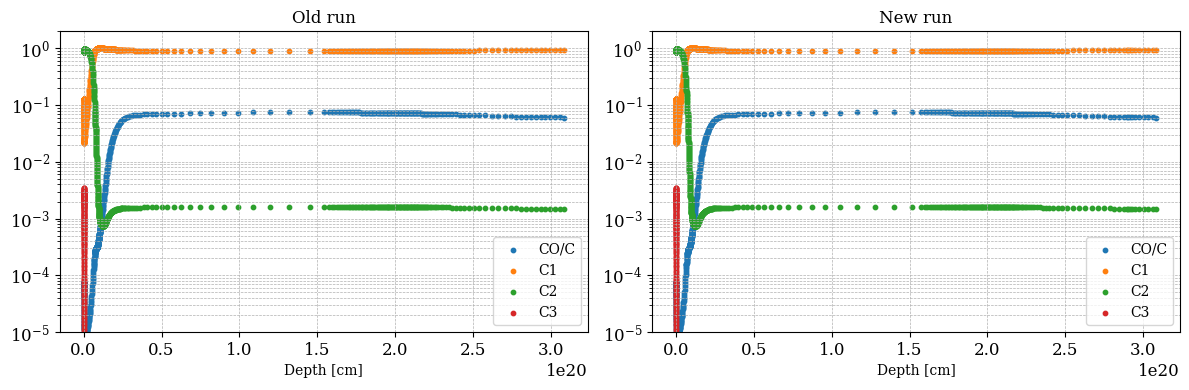

In [3]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, dpi=100, figsize=(12, 4))

for i, (key, value) in enumerate(runs.items()):
    ax = axs[i]
    abundance = value['abundance']
    size = 10
    columns_to_plot = ["CO/C", "C1", "C2", "C3"]
    for column in columns_to_plot:
        ax.scatter(
            abundance['depth'], # cm 
            abundance[column], # 1
            s = size,
            label = column,
        )

    # ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 2])
    ax.set_xlabel("Depth [cm]")
    ax.set_title(value['label'])
    ax.legend()
    ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()




## Emissivity

In [4]:
Aul = 7.203e-08 # 1/s
Pul = 1 # Assuming every photon escapes 
h = 6.626e-27 # erg * s
freq = 1.9e12 # Hz

C_over_H_number_ratio = 2.51e-4 # ~ C/H /home/m/murray/dtolgay/cloudy/c23.00/data/abundances/ISM.abn 

for i, (key, value) in enumerate(runs.items()):

    print(key)

    if key == "run1":
        abundance = value['abundance']

        C_over_H_number_ratio_new = C_over_H_number_ratio * 3
        
        hden = abundance['hden'] # cm-3
        nC = hden * C_over_H_number_ratio_new # cm-3 
        nCO = hden * C_over_H_number_ratio_new * abundance['CO/C']
        
        h_nu_over_k = 91.21 # K 
        T = abundance['Te']
        # g = 2J + 1
        gu=3
        gl=1
        nu_over_nl = gu/gl * np.exp(-h_nu_over_k / T)
        nu_over_ntotal = 1 / ( 1 + 1 / nu_over_nl )
        
        eco = nCO * Aul * Pul * h * freq # erg/s/cm3
        eco_upperStateConsidered = nCO * nu_over_ntotal * Aul * Pul * h * freq # erg/s/cm3
    
        # Put into the dictionary
        value['eco'] = eco
        value['eco_upperStateConsidered'] = eco_upperStateConsidered
        
    else:
        abundance = value['abundance']
        
        hden = abundance['hden'] # cm-3
        nC = hden * C_over_H_number_ratio # cm-3 
        nCO = hden * C_over_H_number_ratio * abundance['CO/C']
        
        h_nu_over_k = 91.21 # K 
        T = abundance['Te']
        # g = 2J + 1
        gu=3
        gl=1
        nu_over_nl = gu/gl * np.exp(-h_nu_over_k / T)
        nu_over_ntotal = 1 / ( 1 + 1 / nu_over_nl )
        
        eco = nCO * Aul * Pul * h * freq # erg/s/cm3
        eco_upperStateConsidered = nCO * nu_over_ntotal * Aul * Pul * h * freq # erg/s/cm3
    
        # Put into the dictionary
        value['eco'] = eco
        value['eco_upperStateConsidered'] = eco_upperStateConsidered
    



original
run2


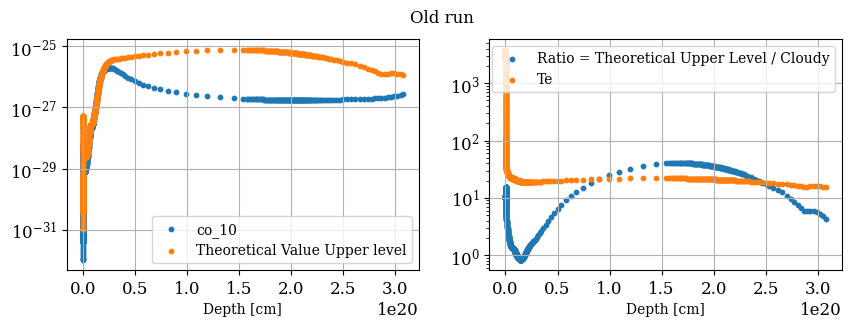

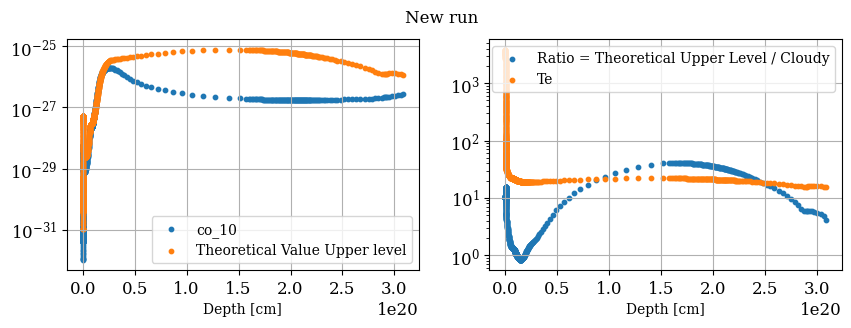

In [5]:

for i, (key, value) in enumerate(runs.items()):

    emissivity = value['emissivity']
    abundance = value['abundance']
    eco = value['eco']
    eco_upperStateConsidered = value['eco_upperStateConsidered']
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3), dpi=100)
    
    size = 10
    
    ax = axs[0]
    # columns_to_plot = ["co_10", "c2"]
    columns_to_plot = ["co_10"]
    for column in columns_to_plot:
        ax.scatter(
            emissivity['depth'], # cm 
            emissivity[column], # erg/s/cm3
            s = size,
            label = column,
        )
    
    # ax.scatter(
    #     emissivity['depth'], 
    #     eco, 
    #     s = size, 
    #     label = "Theoretical Value"
    # )
    
    ax.scatter(
        emissivity['depth'], 
        eco_upperStateConsidered, 
        s = size, 
        label = "Theoretical Value Upper level"
    )
    
    # plt.xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Depth [cm]")
    ax.set_ylabel("")
    ax.legend()
    ax.grid()
    
    
    
    ###########################
    ax = axs[1]
    size = 10
    # plt.scatter(
    #     emissivity['depth'], 
    #     eco / emissivity['co_10'], 
    #     s = size, 
    #     label = "Ratio = Theoretical / Cloudy"
    # )
    
    plt.scatter(
        emissivity['depth'], 
        eco_upperStateConsidered / emissivity['co_10'], 
        s = size, 
        label = "Ratio = Theoretical Upper Level / Cloudy"
    )
    
    plt.scatter(
        abundance['depth'],
        abundance['Te'],
        s = size, 
        label = "Te"
    )
    
    
    # plt.xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Depth [cm]")
    ax.set_ylabel("")
    ax.legend(fontsize=10)
    ax.grid()

    
    plt.suptitle(value['label'])
    plt.show()
